In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras.applications import inception_v3
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, merge
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from random import shuffle
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"
IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos")

HOLIDAY_FILE_IDS = os.path.join(DATA_DIR, "holiday-ids.txt")
HOLIDAY_VECS_FILE = os.path.join(DATA_DIR, "holiday-vecs.npy")

## Prepare Data

We use the naming convention to identify as a positive pair any two images that are part of the same group, and negative as a random pair of images in different groups.

In [3]:
def get_random_image(img_groups, group_names, gid):
    gname = group_names[gid]
    photos = img_groups[gname]
    pid = np.random.choice(np.arange(len(photos)), size=1)[0]
    pname = photos[pid]
    return gname + pname + ".jpg"
    
def create_triples(image_dir):
    img_groups = {}
    for img_file in os.listdir(image_dir):
        prefix, suffix = img_file.split(".")
        gid, pid = prefix[0:4], prefix[4:]
        if img_groups.has_key(gid):
            img_groups[gid].append(pid)
        else:
            img_groups[gid] = [pid]
    pos_triples, neg_triples = [], []
    # positive pairs are any combination of images in same group
    for key in img_groups.keys():
        triples = [(key + x[0] + ".jpg", key + x[1] + ".jpg", 1) 
                 for x in itertools.combinations(img_groups[key], 2)]
        pos_triples.extend(triples)
    # need equal number of negative examples
    group_names = list(img_groups.keys())
    for i in range(len(pos_triples)):
        g1, g2 = np.random.choice(np.arange(len(group_names)), size=2, replace=False)
        left = get_random_image(img_groups, group_names, g1)
        right = get_random_image(img_groups, group_names, g2)
        neg_triples.append((left, right, 0))
    pos_triples.extend(neg_triples)
    shuffle(pos_triples)
    return pos_triples

triples_data = create_triples(IMAGE_DIR)

print(len(triples_data))
print(triples_data[0:5])

4144
[('149600.jpg', '149604.jpg', 1), ('133602.jpg', '133600.jpg', 1), ('104003.jpg', '117201.jpg', 0), ('148200.jpg', '148201.jpg', 1), ('124302.jpg', '143903.jpg', 0)]


Using the triples, we create a cache keyed by image filename and whose value is the numpy vector represented by the image. Since we plan on using pretrained InceptionV3 network, our images are resized to (299, 299, 3).

In [4]:
def load_image_cache(image_cache, image_filename):
    image = plt.imread(os.path.join(IMAGE_DIR, image_filename))
    image = imresize(image, (299, 299))
    image = image.astype("float32")
    image = inception_v3.preprocess_input(image)
    image_cache[image_filename] = image
    
image_cache = {}
num_pairs = len(triples_data)
for i, (image_filename_l, image_filename_r, _) in enumerate(triples_data):
    if i % 1000 == 0:
        print("images from {:d}/{:d} pairs loaded to cache".format(i, num_pairs))
    if not image_cache.has_key(image_filename_l):
        load_image_cache(image_cache, image_filename_l)
    if not image_cache.has_key(image_filename_r):
        load_image_cache(image_cache, image_filename_r)
print("images from {:d}/{:d} pairs loaded to cache, COMPLETE".format(i, num_pairs))

images from 0/4144 pairs loaded to cache
images from 1000/4144 pairs loaded to cache
images from 2000/4144 pairs loaded to cache
images from 3000/4144 pairs loaded to cache
images from 4000/4144 pairs loaded to cache
images from 4143/4144 pairs loaded to cache, COMPLETE


In [5]:
def pair_generator(triples, image_cache, datagens, batch_size=32):
    while True:
        # shuffle once per batch
        indices = np.random.permutation(np.arange(len(triples)))
        num_batches = len(triples) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [triples[i] for i in batch_indices]
            X1 = np.zeros((batch_size, 299, 299, 3))
            X2 = np.zeros((batch_size, 299, 299, 3))
            Y = np.zeros((batch_size, 2))
            for i, (image_filename_l, image_filename_r, label) in enumerate(batch):
                if datagens is None or len(datagens) == 0:
                    X1[i] = image_cache[image_filename_l]
                    X2[i] = image_cache[image_filename_r]
                else:
                    X1[i] = datagens[0].random_transform(image_cache[image_filename_l])
                    X2[i] = datagens[1].random_transform(image_cache[image_filename_r])
                Y[i] = [1, 0] if label == 0 else [0, 1]
            yield [X1, X2], Y


datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2)
datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]
pair_gen = pair_generator(triples_data, image_cache, datagens, 32)
[X1, X2], Y = pair_gen.next()
print(X1.shape, X2.shape, Y.shape)

(32, 299, 299, 3) (32, 299, 299, 3) (32, 2)


## Define Model

The model is composed of two pretrained Inception V3 networks without their last prediction layer, connected to a merge layer that computes element-wise dot product of the two (2048,) sized vectors produced by the Inception V3. This is then fed into a 3 layer fully connected network that produces the similar / not similar prediction.

The Inception V3 network weights are frozen, and the Fully Connected network weights are loaded from one trained using pre-computed image vectors and allowed to be fine-tuned.

In [6]:
# distance measure
def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = cosine_distance(vecs)
print(s.shape)

(10,) (10,)
(10,)


In [7]:
# load 2 copies of the inception model
# in case of a siamese network, the same instance of the network will be trained,
# but in our case the network is untrainable, so we can have 2 copies
inception_1 = inception_v3.InceptionV3(weights="imagenet", include_top=True)
inception_2 = inception_v3.InceptionV3(weights="imagenet", include_top=True)

In [8]:
# Here the last two layers are avg_pool and prediction as shown below:
#    avg_pool (None, 8, 8, 2048) (None, 2048)
#    predictions (None, 2048) (None, 1000)
#
# for layer in inception_1.layers:
#     print(layer.name, layer.input_shape, layer.output_shape)

In [9]:
# freeze weights on the inception network and give each layer a unique name
# since we will combine them into a single network
for layer in inception_1.layers:
    layer.trainable = False
    layer.name = layer.name + "_1"
for layer in inception_2.layers:
    layer.trainable = False
    layer.name = layer.name + "_2"

In [10]:
# outputs of the inception networks, these will be connected to our head FCN
vector_1 = inception_1.get_layer("avg_pool_1").output
vector_2 = inception_2.get_layer("avg_pool_2").output

In [11]:
# load the pretrained similarity head network. This has been trained to predict similar
# images using image vectors
sim_head = load_model(os.path.join(DATA_DIR, "models", "inceptionv3-dot-best.h5"))
for layer in sim_head.layers:
    print(layer.name, layer.input_shape, layer.output_shape)

input_3 (None, 2048) (None, 2048)
input_4 (None, 2048) (None, 2048)
lambda_1 [(None, 2048), (None, 2048)] (None, 2048)
dense_4 (None, 2048) (None, 512)
dropout_3 (None, 512) (None, 512)
activation_4 (None, 512) (None, 512)
dense_5 (None, 512) (None, 128)
dropout_4 (None, 128) (None, 128)
activation_5 (None, 128) (None, 128)
dense_6 (None, 128) (None, 2)
activation_6 (None, 2) (None, 2)


In [12]:
# attach output of the inception networks to the similarity head
# output is a prediction tensor
prediction = sim_head([vector_1, vector_2])

In [13]:
# declare a model that takes image inputs on its truncated Inception subnetworks
# and returns the prediction as the output. Inputs are Input(shape=(299, 299, 3))
model = Model(inputs=[inception_1.input, inception_2.input], outputs=prediction)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Train Network

In [14]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
BEST_MODEL_FILE = os.path.join(DATA_DIR, "models", "inception-ft-best.h5")
FINAL_MODEL_FILE = os.path.join(DATA_DIR, "models", "inception-ft-final.h5")

In [15]:
triples_data_trainval, triples_data_test = train_test_split(triples_data, train_size=0.8)
triples_data_train, triples_data_val = train_test_split(triples_data_trainval, train_size=0.9)
print(len(triples_data_train), len(triples_data_val), len(triples_data_test))

2983 332 829


In [16]:
datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2)
datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]
train_pair_gen = pair_generator(triples_data_train, image_cache, datagens, BATCH_SIZE)
val_pair_gen = pair_generator(triples_data_val, image_cache, None, BATCH_SIZE)

In [17]:
num_train_steps = len(triples_data_train) // BATCH_SIZE
num_val_steps = len(triples_data_val) // BATCH_SIZE

In [18]:
checkpoint = ModelCheckpoint(filepath=BEST_MODEL_FILE, save_best_only=True)
history = model.fit_generator(train_pair_gen, 
                             steps_per_epoch=num_train_steps,
                             epochs=NUM_EPOCHS,
                             validation_data=val_pair_gen,
                             validation_steps=num_val_steps,
                             callbacks=[checkpoint])

Epoch 1/10
93/93 [==============================] - 150s - loss: 0.8327 - acc: 0.5759 - val_loss: 0.5848 - val_acc: 0.5687
Epoch 2/10
93/93 [==============================] - 123s - loss: 0.5829 - acc: 0.6784 - val_loss: 0.5199 - val_acc: 0.7312
Epoch 3/10
93/93 [==============================] - 126s - loss: 0.4994 - acc: 0.7688 - val_loss: 0.4864 - val_acc: 0.8063
Epoch 4/10
93/93 [==============================] - 128s - loss: 0.4420 - acc: 0.7957 - val_loss: 0.4454 - val_acc: 0.8063
Epoch 5/10
93/93 [==============================] - 129s - loss: 0.3982 - acc: 0.8296 - val_loss: 0.4148 - val_acc: 0.8281
Epoch 6/10
93/93 [==============================] - 109s - loss: 0.3725 - acc: 0.8417 - val_loss: 0.4169 - val_acc: 0.8219
Epoch 7/10
93/93 [==============================] - 109s - loss: 0.3316 - acc: 0.8585 - val_loss: 0.4290 - val_acc: 0.8313
Epoch 8/10
93/93 [==============================] - 124s - loss: 0.3313 - acc: 0.8542 - val_loss: 0.3393 - val_acc: 0.8531
Epoch 9/10
93/93

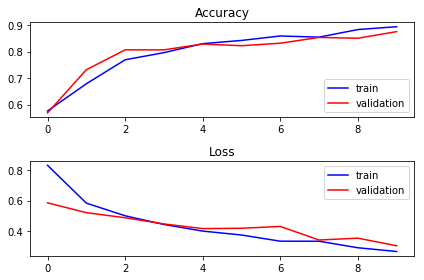

In [19]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="blue", label="train")
plt.plot(history.history["val_acc"], color="red", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="blue", label="train")
plt.plot(history.history["val_loss"], color="red", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [20]:
model.save(FINAL_MODEL_FILE, overwrite=True)

## Predictions

In [21]:
def evaluate_model(model):
    ytest, ytest_ = [], []
    test_pair_gen = pair_generator(triples_data_test, image_cache, None, BATCH_SIZE)
    num_test_steps = len(triples_data_test) // BATCH_SIZE
    curr_test_steps = 0
    for [X1test, X2test], Ytest in test_pair_gen:
        if curr_test_steps > num_test_steps:
            break
        Ytest_ = model.predict([X1test, X2test])
        ytest.extend(np.argmax(Ytest, axis=1).tolist())
        ytest_.extend(np.argmax(Ytest_, axis=1).tolist())
        curr_test_steps += 1
    acc = accuracy_score(ytest, ytest_)
    cm = confusion_matrix(ytest, ytest_)
    return acc, cm

print("==== Evaluation Results: final model on test set ====")
final_model = load_model(FINAL_MODEL_FILE)
acc, cm = evaluate_model(final_model)
print("Accuracy Score: {:.3f}".format(acc))
print("Confusion Matrix")
print(cm)

print("==== Evaluation Results: best model on test set ====")
best_model = load_model(BEST_MODEL_FILE)
acc, cm = evaluate_model(best_model)
print("Accuracy Score: {:.3f}".format(acc))
print("Confusion Matrix")
print(cm)

==== Evaluation Results: final model on test set ====
Accuracy Score: 0.881
Confusion Matrix
[[380  60]
 [ 39 353]]
==== Evaluation Results: best model on test set ====
Accuracy Score: 0.880
Confusion Matrix
[[372  62]
 [ 38 360]]
